In [4]:
# Product BackOrder data analysis and prediction

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
import warnings
warnings.filterwarnings('ignore')
#init_notebook_mode(connected=True)
from subprocess import check_output
print(check_output(["ls", "./data"]).decode("utf8"))

kaggle



In [5]:

# Load the data

train = pd.read_csv('./data/kaggle/kaggle/Kaggle_Training_Dataset_v2.csv')
test = pd.read_csv( './data/kaggle/kaggle/Kaggle_Test_Dataset_v2.csv')
for c, dtype in zip(train.columns, train.dtypes):
    if dtype == np.float64:
        train[c] = train[c].astype(np.float32)
train.info(verbose=False)
test.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1687861 entries, 0 to 1687860
Columns: 23 entries, sku to went_on_backorder
dtypes: float32(15), object(8)
memory usage: 199.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242076 entries, 0 to 242075
Columns: 23 entries, sku to went_on_backorder
dtypes: float64(15), object(8)
memory usage: 42.5+ MB


In [6]:
# Let us do Categorical Analysis

train[train.select_dtypes(include = ['object']).columns].head()

train.drop(train.index[-1], inplace=True)
test.drop(test.index[-1], inplace=True)

train.sku = train.sku.astype(np.int32)
test.sku = test.sku.astype(np.int32)

for c in list(train.select_dtypes(include = ['object']).columns):
    le = LabelEncoder()
    train[c] = le.fit_transform(train[c])
    test[c] = le.transform(test[c])

train['went_on_backorder'].value_counts()

0    1676567
1      11293
Name: went_on_backorder, dtype: int64

In [7]:

# Let us use Pie plot to visualize the data balance which is imbalanced

labels = ['Yes','No']
yes = len(train[train['went_on_backorder']==1])
no = len(train[train['went_on_backorder']==0])
values=[yes, no]
trace = go.Pie(labels=labels, values=values)
plotly.offline.iplot([trace], filename='basic_pie_chart')

In [8]:

# Let us verify this

X, y = train.drop(['lead_time','went_on_backorder'],axis=1), train.went_on_backorder
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Negative class (0) is most frequent Therefore the dummy 'most_frequent' classifier always predicts class 0

dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)

# Let us check the accuracy below
dummy_majority.score(X_test, y_test)

0.9933098716718212

In [9]:

# That is a very high accuracy
# Let us check the NA's and eliminate them by doing imputation

train.isnull().sum()
train['lead_time'].isnull().sum()/train.shape[0]*100

from sklearn.preprocessing import Imputer
train['lead_time'] = Imputer(strategy='median').fit_transform(
                                    train['lead_time'].values.reshape(-1, 1))
test['lead_time'] = Imputer(strategy='median').fit_transform(
                                    test['lead_time'].values.reshape(-1, 1))

In [10]:
# Model selection using evaluation metrics

# K-Fold Cross Validation

# With the help of StratifiedShuffleSplit we will do average sampling

X = train.drop('went_on_backorder', axis=1).values
y = train['went_on_backorder'].values
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
sss.get_n_splits(X, y)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

model = RandomForestClassifier(n_estimators = 100 , max_depth=8, max_features=None,random_state=87)
model.fit(X_train, y_train)
feat_names = train.drop('went_on_backorder', axis=1).columns.values

kaggle

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1687861 entries, 0 to 1687860
Columns: 23 entries, sku to went_on_backorder
dtypes: float32(15), object(8)
memory usage: 199.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242076 entries, 0 to 242075
Columns: 23 entries, sku to went_on_backorder
dtypes: float64(15), object(8)
memory usage: 42.5+ MB


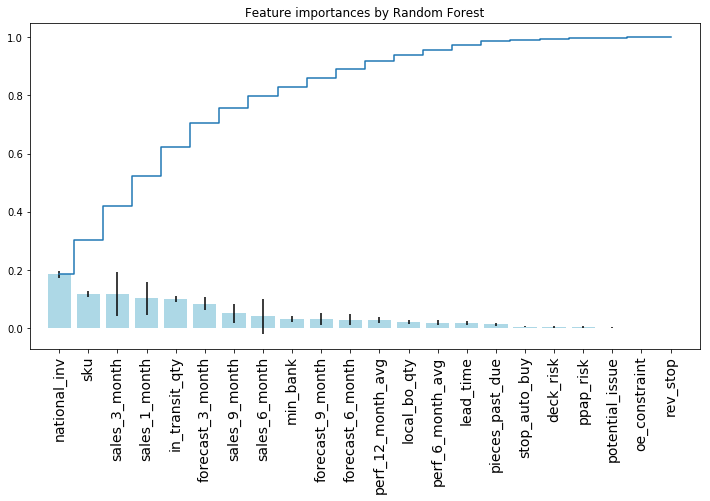

MaxDepth = 2.00  accuracy = 0.99   AUC = 0.8852
MaxDepth = 4.00  accuracy = 0.99   AUC = 0.9166
MaxDepth = 6.00  accuracy = 0.99   AUC = 0.9272
MaxDepth = 10.00  accuracy = 0.99   AUC = 0.9475


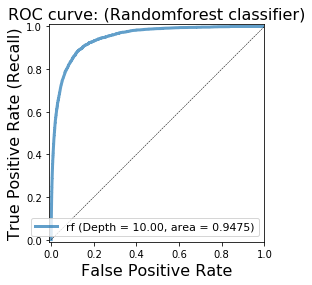

In [3]:





# plot the importances

importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,6))
plt.title("Feature importances by Random Forest")
plt.bar(range(len(indices)), importances[indices], color='lightblue', yerr=std[indices], align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
for g in [2, 4, 6, 10]:
    rf = RandomForestClassifier(max_depth=g,random_state=0).fit(X_train, y_train)
    y_score_rf = rf.predict_proba(X_test)
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_score_rf[:,1])
    roc_auc_rf = auc(fpr_rf, tpr_rf)
    accuracy_rf = rf.score(X_test, y_test)
    print("MaxDepth = {:.2f}  accuracy = {:.2f}   AUC = {:.4f}".format(g, accuracy_rf, roc_auc_rf))

plt.plot(fpr_rf, tpr_rf, lw=3, alpha=0.7, label='rf (Depth = {:0.2f}, area = {:0.4f})'.format(g, roc_auc_rf))

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate (Recall)', fontsize=16)
plt.plot([0, 1], [0, 1], color='k', lw=0.5, linestyle='--')
plt.legend(loc="lower right", fontsize=11)
plt.title('ROC curve: (Randomforest classifier)', fontsize=16)
plt.axes().set_aspect('equal')
plt.show()